### Softmax
将逻辑分类转化为0-1的概率分类，实现2元问题转向多元问题
$$ \sigma(z)_j =\frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}, j = 1,...,K \tag{1}$$

**使用之前的海绵宝宝数据集进行softmax预测**

Lab/data/SpongeBob SquarePants/

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 根据需要调整图像大小
    transforms.ToTensor(),
])

# 加载数据集
data_dir = r'D:\machine_learning\DeepL\Lab\data\SpongeBob SquarePants'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 获取图像和标签
X = []
y = []
for img, label in dataset:
    X.append(img)
    y.append(label)

# 将列表转换为张量
X_tensor = torch.stack(X)
y_tensor = torch.LongTensor(y)

# 将数据分为训练集和测试集
seed = 43
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=seed)

# 创建 DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)


Softmax 不需要在模型中显式实现：使用 nn.CrossEntropyLoss() 会自动处理 Softmax。  
在进行预测时，可以使用 torch.softmax：这样可以获得每个类的概率  
`input layer -> linear -> relu -> output -> softmax -> y`  
`softmax` 在模型外进行，不定义在模型内

In [2]:
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(128 * 128 * 3, 128)  # 输入层
        self.fc2 = nn.Linear(128, 6)  # 输出层

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平
        x = torch.relu(self.fc1(x))  # ReLU 激活
        x = self.fc2(x)  # 输出层
        return x

model = SimpleNN()

In [3]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# 训练模型
num_epochs = 300
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()  # 清除上一步的梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch + 1)% 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')


Epoch [10/300], Loss: 1.60034120
Epoch [20/300], Loss: 1.17720711
Epoch [30/300], Loss: 0.93048233
Epoch [40/300], Loss: 0.73086452
Epoch [50/300], Loss: 0.57826948
Epoch [60/300], Loss: 0.46212479
Epoch [70/300], Loss: 0.37310532
Epoch [80/300], Loss: 0.30473456
Epoch [90/300], Loss: 0.25185242
Epoch [100/300], Loss: 0.21071623
Epoch [110/300], Loss: 0.17840983
Epoch [120/300], Loss: 0.15275741
Epoch [130/300], Loss: 0.13218322
Epoch [140/300], Loss: 0.11544255
Epoch [150/300], Loss: 0.10167769
Epoch [160/300], Loss: 0.09022857
Epoch [170/300], Loss: 0.08061597
Epoch [180/300], Loss: 0.07247059
Epoch [190/300], Loss: 0.06551374
Epoch [200/300], Loss: 0.05952354
Epoch [210/300], Loss: 0.05432995
Epoch [220/300], Loss: 0.04979700
Epoch [230/300], Loss: 0.04581873
Epoch [240/300], Loss: 0.04230603
Epoch [250/300], Loss: 0.03918972
Epoch [260/300], Loss: 0.03641284
Epoch [270/300], Loss: 0.03392651
Epoch [280/300], Loss: 0.03169163
Epoch [290/300], Loss: 0.02967529
Epoch [300/300], Loss: 

In [5]:
# 进行预测
model.eval()  # 设置模型为评估模式
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)  # 获取模型输出
        probabilities = torch.softmax(outputs, dim=1)  # 应用 Softmax
        predicted_classes = torch.argmax(probabilities, dim=1)  # 获取预测类别
        
        total += labels.size(0)  # 累计总样本数
        correct += (predicted_classes == labels).sum().item()  # 统计正确预测数

accuracy = correct / total  # 计算准确率
print(f'Accuracy: {accuracy * 100:.2f}%')

correct = 0
total = 0
with torch.no_grad():
    for images, labels in train_dataloader:
        outputs = model(images)  # 获取模型输出
        probabilities = torch.softmax(outputs, dim=1)  # 应用 Softmax
        predicted_classes = torch.argmax(probabilities, dim=1)  # 获取预测类别
        
        total += labels.size(0)  # 累计总样本数
        correct += (predicted_classes == labels).sum().item()  # 统计正确预测数

accuracy = correct / total  # 计算准确率
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 50.00%
Accuracy: 100.00%


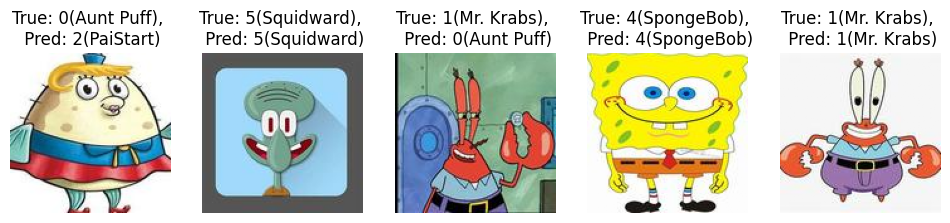

In [6]:
import random
from matplotlib import pyplot as plt
n = 5
images, labels = next(iter(test_dataloader))  # 从 DataLoader 中取出一批数据
indices = random.sample(range(len(images)), n)  # 随机选择索引
selected_images = images[indices]  # 选择图片并移动到设备
selected_labels = labels[indices]  # 对应标签

# 进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)  # 预测类别

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0)) 
    true_label = dataset.classes[selected_labels[i].item()]  # 获取真实标签名称
    pred_label = dataset.classes[predicted[i].item()]  # 获取预测标签名称
    plt.title(f'True: {selected_labels[i].item()}({true_label}), \n Pred: {predicted[i].item()}({pred_label})')
    plt.axis('off')  # 关闭坐标轴

plt.show()

可见1层Hidden起初的效果并不是很理想，下面我们尝试对其进行调整  

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(128 * 128 * 3, 128)  # 第一层隐藏层
        self.fc2 = nn.Linear(128, 64)              # 第二层隐藏层
        self.fc3 = nn.Linear(64, 32)               # 第三层隐藏层
        self.fc4 = nn.Linear(32, 6)                # 输出层

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展平输入
        x = torch.relu(self.fc1(x)) # 第一层激活
        x = torch.relu(self.fc2(x)) # 第二层激活
        x = torch.relu(self.fc3(x)) # 第三层激活
        x = self.fc4(x)             # 输出层
        return x

In [8]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# 训练模型
num_epochs = 300
for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        optimizer.zero_grad()  # 清除上一步的梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
    if (epoch + 1)% 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')
# 进行预测
model.eval()  # 设置模型为评估模式
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)  # 获取模型输出
        probabilities = torch.softmax(outputs, dim=1)  # 应用 Softmax
        predicted_classes = torch.argmax(probabilities, dim=1)  # 获取预测类别
        
        total += labels.size(0)  # 累计总样本数
        correct += (predicted_classes == labels).sum().item()  # 统计正确预测数

accuracy = correct / total  # 计算准确率
print(f'Accuracy: {accuracy * 100:.2f}%')


Epoch [10/300], Loss: 0.02700643
Epoch [20/300], Loss: 0.01853401
Epoch [30/300], Loss: 0.01667404
Epoch [40/300], Loss: 0.01256308
Epoch [50/300], Loss: 0.01232345
Epoch [60/300], Loss: 0.00931543
Epoch [70/300], Loss: 0.00916202
Epoch [80/300], Loss: 0.00831944
Epoch [90/300], Loss: 0.00760205
Epoch [100/300], Loss: 0.00549741
Epoch [110/300], Loss: 0.00522040
Epoch [120/300], Loss: 0.00543734
Epoch [130/300], Loss: 0.00352031
Epoch [140/300], Loss: 0.00369856
Epoch [150/300], Loss: 0.00377338
Epoch [160/300], Loss: 0.00392192
Epoch [170/300], Loss: 0.00332985
Epoch [180/300], Loss: 0.00251421
Epoch [190/300], Loss: 0.00245701
Epoch [200/300], Loss: 0.00281926
Epoch [210/300], Loss: 0.00229783
Epoch [220/300], Loss: 0.00130969
Epoch [230/300], Loss: 0.00233706
Epoch [240/300], Loss: 0.00179558
Epoch [250/300], Loss: 0.00113692
Epoch [260/300], Loss: 0.00156485
Epoch [270/300], Loss: 0.00108172
Epoch [280/300], Loss: 0.00129363
Epoch [290/300], Loss: 0.00103895
Epoch [300/300], Loss: 

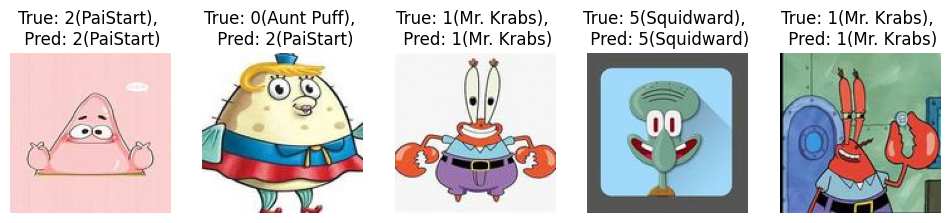

In [11]:
import random
n = 5
images, labels = next(iter(test_dataloader))  # 从 DataLoader 中取出一批数据
indices = random.sample(range(len(images)), n)  # 随机选择索引
selected_images = images[indices]  # 选择图片并移动到设备
selected_labels = labels[indices]  # 对应标签

# 进行预测
model.eval()  # 设置模型为评估模式
with torch.no_grad():
    outputs = model(selected_images)
    _, predicted = torch.max(outputs, 1)  # 预测类别

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(selected_images[i].cpu().numpy().transpose(1, 2, 0)) 
    true_label = dataset.classes[selected_labels[i].item()]  # 获取真实标签名称
    pred_label = dataset.classes[predicted[i].item()]  # 获取预测标签名称
    plt.title(f'True: {selected_labels[i].item()}({true_label}), \n Pred: {predicted[i].item()}({pred_label})')
    plt.axis('off')  # 关闭坐标轴

plt.show()

**数据集的规模和多样性**: 如果数据集较小或数据样本过于相似，模型可能容易学会简单的模式，这可能导致相似的准确率。即使损失函数的值不同，模型对数据的分类能力可能保持不变。  
**过拟合现象**: 在较小的数据集上，模型可能在训练集上表现良好但在测试集上并没有太大区别，这导致训练过程中的 loss 和准确率看似一致。这种情况在训练时优化目标与评估指标不一致时尤为常见。  
**损失函数的选择**: 使用不同的损失函数可能导致不同的训练损失，但这并不一定反映在模型的准确率上。尤其是在分类任务中，可能有些损失函数对结果的敏感度不同。  
**预测的阈值**: 准确率通常基于一个固定的阈值来判断分类结果。如果两个模型的预测分布相似，但阈值设定相同，可能会导致准确率一致。  
**模型训练的稳定性**: 不同的训练轮次、随机初始化、batch size 等因素可能导致训练过程中的不稳定性，使得损失值有所变化，但准确率在某个范围内保持稳定。  